# Introduction to Data Science
## From correlation to supervised segmentation and tree-structured models
Fall 2019 

Teacher Assistant: Shibo Yao


***

### Packages and functions

We are going to need a lot of Python **packages**, so let's start by importing all of them.

In [6]:
# Import the libraries we will be using

import os
import numpy as np
import pandas as pd
import math
import matplotlib.patches as patches
import matplotlib.pylab as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
#from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn import datasets
from IPython.display import Image

%matplotlib inline

We are also going to do a lot of repetitive stuff, so let's predefine some useful **FUNCTIONS**:

Remember the basic aspects of a function:

* Input -> Parameters
* Actions
* Output -> Return

(We might have no _return_ which is basically just an action usually known as procedure. Also, We will see in other classes that these functions can also be taken from a **SCRIPT !!!**)


In [7]:

# A function that gives a visual representation of the decision tree

def Decision_Tree_Image(decision_tree, feature_names, name="temp"):
    
    # Export our decision tree to graphviz format
   # dot_file = tree.export_graphviz(decision_tree.tree_, out_file='images/' + name + '.dot', feature_names=feature_names)
     #dot_file = export_graphviz(decision_tree.tree_, out_file='images/' + name + '.dot', feature_names=feature_names)
    dot_file = tree.export_graphviz(decision_tree, out_file='images/' + name + '.dot', feature_names=feature_names)
    
    # Call graphviz to make an image file from our decision tree
    os.system("dot -T png images/" + name + ".dot -o images/" + name + ".png")
    
    # Return the .png image so we can see it
    return Image(filename='images/' + name + '.png')






### Data creation

We also need some data, so let's create a dataset consisting of **500** people (rows) with **3** different variables (columns). 

The **target** of this dataset will be a feature called "success" ( **binary** -> 0/1 values ).

In [8]:
help(datasets.make_classification)

Help on function make_classification in module sklearn.datasets._samples_generator:

make_classification(n_samples=100, n_features=20, *, n_informative=2, n_redundant=2, n_repeated=0, n_classes=2, n_clusters_per_class=2, weights=None, flip_y=0.01, class_sep=1.0, hypercube=True, shift=0.0, scale=1.0, shuffle=True, random_state=None)
    Generate a random n-class classification problem.
    
    This initially creates clusters of points normally distributed (std=1)
    about vertices of an ``n_informative``-dimensional hypercube with sides of
    length ``2*class_sep`` and assigns an equal number of clusters to each
    class. It introduces interdependence between these features and adds
    various types of further noise to the data.
    
    Without shuffling, ``X`` horizontally stacks features in the following
    order: the primary ``n_informative`` features, followed by ``n_redundant``
    linear combinations of the informative features, followed by ``n_repeated``
    duplicates, dr

In [9]:
# Set the randomness
np.random.seed(36)

# Number of users
n_users = 1000

# Relationships
variable_names = ["age", "humor", "number_pets"]
variables_keep = ["number_pets", "humor"]
target_name = "success"

# Generate data with the "datasets" function from SKLEARN (package)
# This function returns two variables: predictors and target

predictors, target = datasets.make_classification(n_features=3, n_redundant=0, 
                                                 n_informative=2, n_clusters_per_class=2,
                                                  n_samples=n_users)

# We will write this data in a dataframe (pandas package)

data = pd.DataFrame(predictors, columns=variable_names)

# We want to take each column of the dataframe to change the values 

data['age'] = data['age'] * 10 + 50
data['humor'] = data['humor'] * 10 + 50
data['number_pets'] = (data['number_pets'] + 6)/2
data[target_name] = target

# Our variables (features) will be stored in one variable called X
X = data[[variables_keep[0], variables_keep[1]]]

# Our target will be stored in one variable called Y
Y = data[target_name]


We can (and should) take a look at the first few rows/records of our data to see what we are dealing with.

In [10]:
# Last 5 values

X.tail(10)

,number_pets,humor
990,4.374242,41.913987
991,2.956402,53.468878
992,3.870342,46.421557
993,2.633099,50.202846
994,3.313870,42.531290
995,3.683295,69.000596
996,2.754218,54.402017
997,4.236264,33.962755
998,4.411274,55.912401
999,2.583996,31.373913


In [11]:
# Success variable: target

Y.tail(10)

990    1
991    1
992    1
993    1
994    1
995    1
996    1
997    1
998    1
999    0
Name: success, dtype: int64

### One feature and splits
Let's take a look at one of our features -- **`"number_pets"`**. Is this feature useful? 

- Let's plot the possible values of `"number_pets"` and color code our target variable, which is, in this case, `"success"`.

- In other words, the horizontal value is the number of pets they have. We can distinguish red dots meaning unsuccessful people and blue dots meaning successful people. The vertical position here doesn't mean anything (everyone has a one). 

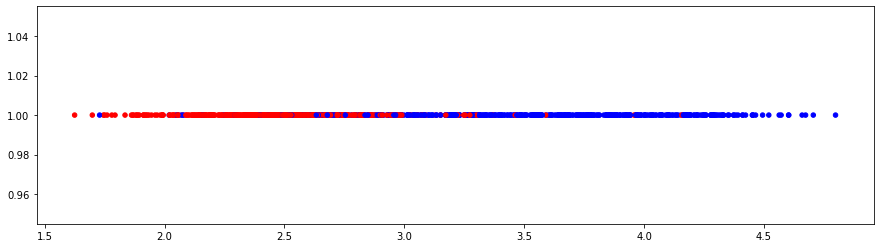

In [12]:

plt.rcParams['figure.figsize'] = [15.0, 4.0]

color = ["red" if x == 0 else "blue" for x in data["success"]]

plt.scatter(X['number_pets'], [1] * n_users, c=color, s=20)


***

Can we say that a number of pets below 3 is a good point to differentiate succesful?  Let's quantify it.



**Entropy** ($H$) and **information gain** ($IG$) are crucial in determining which features are the most informative. 


##### Functions to get the entropy and IG

In [13]:
#list1=np.array([9,10,11,12])
#list2=[True, False, True, False]
#print (list1[list2])
#count=0
#for threshold in X['number_pets']:
#    count +=1;
#    print(count)

In [14]:

def entropy(target):
    # Get the number of instances
    n = len(target)
    # Count how frequently each unique target value occurs using the numpy function 
    counts = np.bincount(target).astype(float)
    
   
    # Initialize entropy
    entropy = 0
    
    # Otherwise, for each possible value, update entropy; use zero for 0 log 0
    for count in counts:
        if count == 0:
            entropy += 0
        else:
            entropy += math.log(count/n, 2) * count/n
    # Return entropy
    return -1 * entropy

def information_gain(feature, threshold, target):
    # Dealing with numpy arrays makes this slightly easier
    target = np.array(target)
    feature = np.array(feature)
    # Cut the feature vector on the threshold
    feature = (feature < threshold)
    # Initialize information gain with the parent entropy
    ig = entropy(target)
    # For both sides of the threshold, update information gain
    for level, count in zip([0, 1], np.bincount(feature).astype(float)):
        ig -= count/len(feature) * entropy(target[feature == level])
    # Return information gain
    return ig

Now that we have a way of calculating $H$ and $IG$, let's pick a threshold, split `"number_pets"`, and calculate $IG$.

In [15]:

threshold = 3
print ("IG = %.4f with thresholding of %.2f." % (information_gain(X['number_pets'], threshold, np.array(Y)), threshold))


IG = 0.4686 with thresholding of 3.00.


In [16]:
print(Y)

0      1
1      0
2      0
3      1
4      1
      ..
995    1
996    1
997    1
998    1
999    0
Name: success, Length: 1000, dtype: int64


To be more precise, we can iterate through all values and find the best split.

In [17]:
#X['number_pets']

In [18]:

def best_threshold():
    maximum_ig = 0
    maximum_threshold = 0

    for threshold in X['number_pets']:
        ig = information_gain(X['number_pets'], threshold, np.array(Y))
        if ig > maximum_ig:
            maximum_ig = ig
            maximum_threshold = threshold

    return "The maximum IG = %.3f and it occured by splitting on %.4f." % (maximum_ig, maximum_threshold)

print ( best_threshold() )


The maximum IG = 0.481 and it occured by splitting on 2.8862.


### All features and splits with the sklearn package !

Let's see how we can do this with just sklearn! Now, we will be using all the variables in X, not only number of pets!

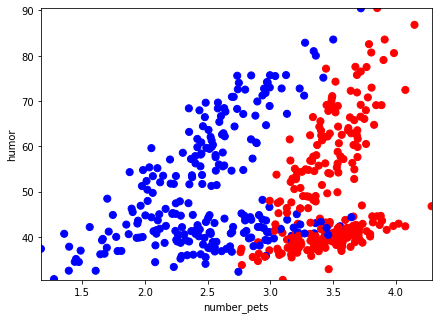

In [15]:
# A function to plot the data

def Plot_Data(data, v1, v2, tv):
    # Make the plot square
    plt.rcParams['figure.figsize'] = [12.0, 8.0]
    
    # Color
    color = ["red" if x == 1 else "blue" for x in data[tv]]
    
    # Plot and label
    plt.scatter(data[v1], data[v2], c=color, s=50)
    plt.xlabel(v1)
    plt.ylabel(v2)
    plt.xlim([min(data[v1]) , max(data[v1]) ])
    plt.ylim([min(data[v2]) , max(data[v2]) ])
    

plt.figure(figsize=[7,5])
Plot_Data(data, "number_pets",  "humor","success")

In [13]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree._classes:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, ccp_alpha=0.0)
 |  
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best ran

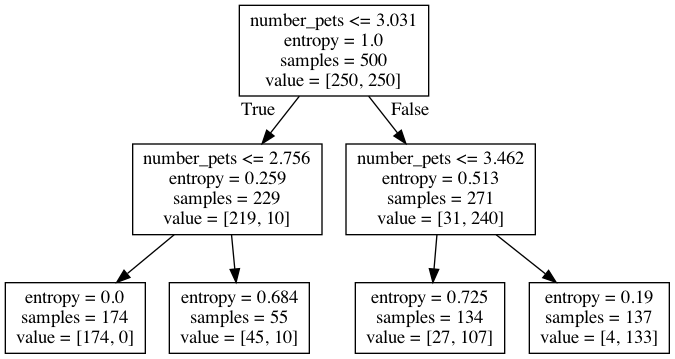

In [20]:

# Let's define the model (tree)
decision_tree = DecisionTreeClassifier(max_depth=2,criterion="entropy")   # Look at those 2 arguments !!! 

# Let's tell the model what is the data
decision_tree.fit(X, Y)

#Let's print an image with the results
Decision_Tree_Image(decision_tree, X.columns)


In [15]:
help(DecisionTreeClassifier)

Help on class DecisionTreeClassifier in module sklearn.tree._classes:

class DecisionTreeClassifier(sklearn.base.ClassifierMixin, BaseDecisionTree)
 |  DecisionTreeClassifier(*, criterion='gini', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight=None, ccp_alpha=0.0)
 |  
 |  A decision tree classifier.
 |  
 |  Read more in the :ref:`User Guide <tree>`.
 |  
 |  Parameters
 |  ----------
 |  criterion : {"gini", "entropy"}, default="gini"
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |  
 |  splitter : {"best", "random"}, default="best"
 |      The strategy used to choose the split at each node. Supported
 |      strategies are "best" to choose the best split and "random" to choose
 |      the best ran

Let's look at the `"humor"`and `"number_pets"`, including the **DECISION SURFACE!!**

More details for this graph: [sklearn decision surface](http://scikit-learn.org/stable/auto_examples/tree/plot_iris.html)

In [18]:
# A function that creates the surface of a decision tree

def Decision_Surface(data, target, model):
    # Get bounds
    x_min, x_max = data[data.columns[0]].min(), data[data.columns[0]].max()
    y_min, y_max = data[data.columns[1]].min(), data[data.columns[1]].max()
    
    # Create a mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max,0.01), np.arange(y_min, y_max,0.01))
    meshed_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])

    
    plt.figure(figsize=[12,7])
    Z = model.predict(meshed_data).reshape(xx.shape)
  
    
    plt.title("Decision surface")    
    plt.ylabel("humor")
    plt.xlabel("number_pets")
    cs = plt.contourf(xx, yy, Z, levels=[-1,0,1],cmap=plt.cm.coolwarm,origin='lower')

    color = ["blue" if t == 0 else "red" for t in target]
    plt.scatter(data[data.columns[0]], data[data.columns[1]], color=color )    

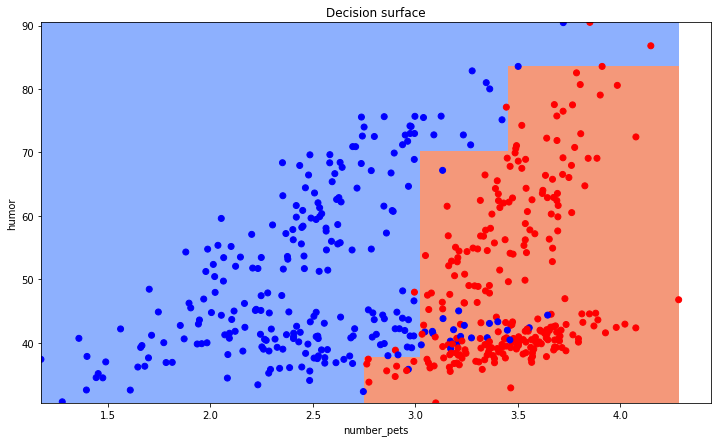

In [19]:
Decision_Surface(X,Y,decision_tree)

In [18]:
print ( "Accuracy = %.3f" % (metrics.accuracy_score(decision_tree.predict(X), Y)) )

Accuracy = 0.950


In [19]:
help(plt.contourf)

Help on function contourf in module matplotlib.pyplot:

contourf(*args, data=None, **kwargs)
    Plot contours.
    
    Call signature::
    
        contour([X, Y,] Z, [levels], **kwargs)
    
    `.contour` and `.contourf` draw contour lines and filled contours,
    respectively.  Except as noted, function signatures and return values
    are the same for both versions.
    
    Parameters
    ----------
    X, Y : array-like, optional
        The coordinates of the values in *Z*.
    
        *X* and *Y* must both be 2-D with the same shape as *Z* (e.g.
        created via `numpy.meshgrid`), or they must both be 1-D such
        that ``len(X) == M`` is the number of columns in *Z* and
        ``len(Y) == N`` is the number of rows in *Z*.
    
        If not given, they are assumed to be integer indices, i.e.
        ``X = range(M)``, ``Y = range(N)``.
    
    Z : array-like(N, M)
        The height values over which the contour is drawn.
    
    levels : int or array-like, option